In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor

In [2]:
data=pd.read_csv("chf.csv")

In [3]:
data

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0
...,...,...,...,...,...,...,...,...,...,...
1860,1861,Richenderfer,plate,1.01,1500,-0.0218,15.0,120.0,10,9.4
1861,1862,Richenderfer,plate,1.01,1500,-0.0434,15.0,120.0,10,10.4
1862,1863,Richenderfer,plate,1.01,2000,-0.0109,15.0,120.0,10,10.8
1863,1864,Richenderfer,plate,1.01,2000,-0.0218,15.0,120.0,10,10.9


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1865 non-null   int64  
 1   author               1865 non-null   object 
 2   geometry             1865 non-null   object 
 3   pressure [MPa]       1865 non-null   float64
 4   mass_flux [kg/m2-s]  1865 non-null   int64  
 5   x_e_out [-]          1865 non-null   float64
 6   D_e [mm]             1865 non-null   float64
 7   D_h [mm]             1865 non-null   float64
 8   length [mm]          1865 non-null   int64  
 9   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 145.8+ KB


In [5]:
data.head(5)

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [6]:
def preprocessing(df):
    df=df.copy()
    df=df.drop(['id','author'], axis=1)
    #split daatframe
    y=df['chf_exp [MW/m2]']
    x=df.drop(['chf_exp [MW/m2]'],axis=1)

    return x ,y

In [7]:
X,y=preprocessing(data)

In [9]:
X

,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm]
0,tube,0.39,5600,-0.1041,3.0,3.0,100
1,tube,0.31,6700,-0.0596,3.0,3.0,100
2,tube,0.33,4300,-0.0395,3.0,3.0,100
3,tube,0.62,6400,-0.1460,3.0,3.0,100
4,tube,0.64,4700,-0.0849,3.0,3.0,100
...,...,...,...,...,...,...,...
1860,plate,1.01,1500,-0.0218,15.0,120.0,10
1861,plate,1.01,1500,-0.0434,15.0,120.0,10
1862,plate,1.01,2000,-0.0109,15.0,120.0,10
1863,plate,1.01,2000,-0.0218,15.0,120.0,10


In [12]:
def build_model():

    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('nominal', nominal_transformer, ['geometry'])
    ], remainder='passthrough')

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=1))
    ])

    return model

In [13]:
kf = KFold(n_splits=5)

rmses = []

for train_idx, test_idx in kf.split(X):

    X_train = X.iloc[train_idx, :]
    X_test = X.iloc[test_idx, :]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    model = build_model()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(np.mean((y_test - y_pred)**2))

    rmses.append(rmse)

final_rmse = np.mean(rmses)

In [14]:
print("RMSE: {:.2f}".format(final_rmse))

RMSE: 1.27


In [15]:
y_test.describe()


,chf_exp [MW/m2]
count,373.000000
mean,3.574799
std,1.828745
min,0.900000
25%,2.500000
50%,3.300000
75%,4.100000
max,14.700000


<Axes: ylabel='Frequency'>

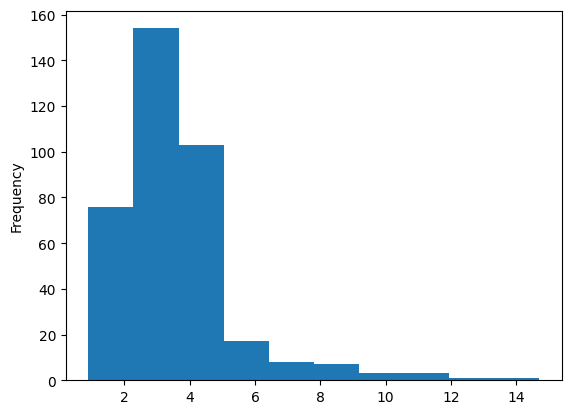

In [16]:
y_test.plot(kind='hist')

In [ ]:
!jupyter nbconvert --to html /content/Assignment2_BT21MEC078.ipynb
